# Import library

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

from PIL import Image
import os
import sys
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Prepare data

In [155]:
# Transform data
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ColorJitter(saturation=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
    
    'val': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
}

In [156]:
path = '/content/drive/MyDrive/EE3063/HW9/image'
batch_size = 8
num_classes = 10


data = {x: datasets.ImageFolder(os.path.join(path, x), data_transforms[x]) 
              for x in ['train', 'val']}

# Load data
train_data = DataLoader(data['train'], batch_size, shuffle=True)
val_data = DataLoader(data['val'], batch_size, shuffle=True)

train_size = len(data['train'])
val_size = len(data['val'])
print(train_size)
print(val_size)

113
40


In [157]:
class_names = data['train'].classes
print(class_names)

['Plastic Screw Anchors', 'bolts', 'hammer', 'hex nuts', 'paper knives', 'pliers', 'screw', 'screwdriver', 'soldering iron', 'wrench']


# Load model

In [158]:
alexnet = models.alexnet(pretrained=True)
model = alexnet

for para in model.parameters():
  para.requires_grad = False

model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model.classifier.add_module("7", nn.LogSoftmax(dim = 1))

print(model)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Trainning

In [159]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()
    history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Trainning
        model.train()
        for train_x, train_y in train_data:
          train_x = train_x.to(device)
          train_y = train_y.to(device)
          
          output_train = model(train_x)
          loss_train = criterion(output_train, train_y)

          # zero the parameter gradients
          optimizer.zero_grad()
          loss_train.backward()
          
          # gradient descent or adam step
          optimizer.step()

          train_loss += loss_train.item() * train_x.size(0)

          _, train_pred = torch.max(output_train.data, 1)
          correct_train = train_pred.eq(train_y.data.view_as(train_pred))
          acc_train = torch.mean(correct_train.type(torch.FloatTensor))
          train_acc += acc_train.item() * train_x.size(0)

        # Validation
        with torch.no_grad():
          model.eval()

          for val_x, val_y in val_data:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            
            output_val = model(val_x)
            loss_val = criterion(output_val, val_y)

            val_loss += loss_val.item() * val_x.size(0)

            _, val_pred = torch.max(output_val.data, 1)
            correct_val = val_pred.eq(val_y.data.view_as(val_pred))
            acc_val = torch.mean(correct_val.type(torch.FloatTensor))
            val_acc += acc_val.item() * val_x.size(0)


        avg_train_loss = train_loss / train_size
        avg_train_acc = train_acc / train_size
        avg_val_loss = val_loss / val_size
        avg_val_acc = val_acc / val_size   

        history.append([avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])    

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', avg_train_loss, avg_train_acc))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', avg_val_loss, avg_val_acc))

        # deep copy the model
        if avg_val_acc >= best_acc:
          best_acc = avg_val_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [160]:
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [161]:
model, history = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------
train Loss: 2.2768 Acc: 0.1947
val Loss: 1.0569 Acc: 0.6000
Epoch 1/14
----------
train Loss: 0.4986 Acc: 0.8496
val Loss: 0.9164 Acc: 0.6500
Epoch 2/14
----------
train Loss: 0.2377 Acc: 0.9381
val Loss: 0.8359 Acc: 0.6500
Epoch 3/14
----------
train Loss: 0.1164 Acc: 0.9735
val Loss: 0.7924 Acc: 0.6750
Epoch 4/14
----------
train Loss: 0.0815 Acc: 0.9912
val Loss: 0.7277 Acc: 0.7500
Epoch 5/14
----------
train Loss: 0.0612 Acc: 1.0000
val Loss: 0.7376 Acc: 0.7500
Epoch 6/14
----------
train Loss: 0.0611 Acc: 0.9823
val Loss: 0.7747 Acc: 0.7750
Epoch 7/14
----------
train Loss: 0.0410 Acc: 0.9912
val Loss: 0.7912 Acc: 0.7500
Epoch 8/14
----------
train Loss: 0.0383 Acc: 0.9912
val Loss: 0.8042 Acc: 0.7500
Epoch 9/14
----------
train Loss: 0.0272 Acc: 1.0000
val Loss: 0.7393 Acc: 0.8000
Epoch 10/14
----------
train Loss: 0.0419 Acc: 1.0000
val Loss: 0.7496 Acc: 0.7750
Epoch 11/14
----------
train Loss: 0.0254 Acc: 1.0000
val Loss: 0.7736 Acc: 0.7250
Epoch 12/14
--

In [175]:
torch.save(model, "/content/drive/MyDrive/EE3063/HW9/model_" + str(1) + ".pt")

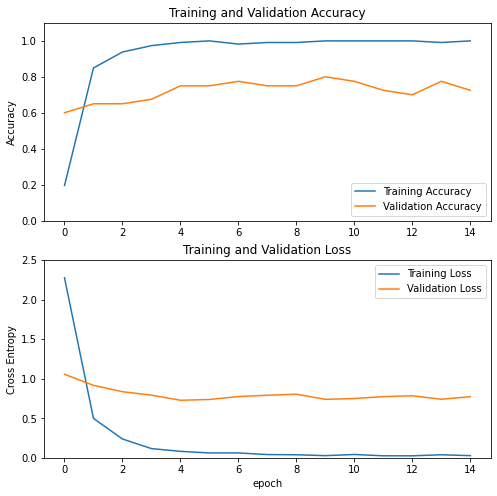

In [162]:
acc = []
val_acc = []
loss = []
val_loss = []
for i in range(15):
  acc.append(history[i][2])
  val_acc.append(history[i][3])
  loss.append(history[i][0])
  val_loss.append(history[i][1])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation

In [163]:
# Load image
path = '/content/drive/MyDrive/EE3063/HW9/test/'
file_name = os.listdir(path)
images = [Image.open(path + name) for name in file_name]
print(len(images))

40


In [164]:
#Get labels
labels = [name.split(name[-6])[0] for name in file_name]
print(labels)

['bolts', 'bolts', 'hammer', 'bolts', 'hammer', 'hammer', 'hammer', 'hex nuts', 'hex nuts', 'hex nuts', 'hex nuts', 'paper knives', 'paper knives', 'bolts', 'wrench', 'wrench', 'wrench', 'wrench', 'Plastic Screw Anchors', 'Plastic Screw Anchors', 'Plastic Screw Anchors', 'paper knives', 'Plastic Screw Anchors', 'pliers', 'pliers', 'pliers', 'paper knives', 'pliers', 'screw', 'screw', 'screw', 'screwdriver', 'soldering iron', 'soldering iron', 'screwdriver', 'soldering iron', 'screw', 'screwdriver', 'screwdriver', 'soldering iron']


In [165]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [166]:
transform_imgs = torch.empty(0, 3, 224, 224)
for img in images:
  tf_img = preprocess(img)
  tensor_img = torch.unsqueeze(tf_img, 0)
  transform_imgs = torch.cat((transform_imgs, tensor_img), dim = 0)

print(transform_imgs.shape)

torch.Size([40, 3, 224, 224])


In [167]:
# Read the categories
with open("/content/drive/MyDrive/EE3063/HW9/classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [168]:
predictions = model(transform_imgs.cuda())
output = torch.nn.functional.softmax(predictions, dim=-1)

In [169]:
# Show top categories per image
top3_prob, top3_id = torch.topk(output, 3)
true = 0

for i in range(top3_id.shape[0]):
  if categories[top3_id[i][0]].startswith(labels[i]):
    true += 1
  if categories[top3_id[i][1]].startswith(labels[i]):
    true += 1
  if categories[top3_id[i][2]].startswith(labels[i]):
    true += 1

print('Top-3 error rate: %.2f' %(100*(1-true/top3_id.shape[0])))

Top-3 error rate: 10.00


In [170]:
# Show top categories per image
top1_prob, top1_id = torch.topk(output, 1)
true = 0

for i in range(top1_id.shape[0]):
  if categories[top1_id[i][0]].startswith(labels[i]):
    true += 1

print('Top-1 error rate: %.2f' %(100*(1-true/top1_id.shape[0])))

Top-1 error rate: 32.50


In [ ]:
# View top 5 class for each image
for i in range(40):
  print('Image %s' %(file_name[i]))
  for j in range(3):
    print(' %s   with accuracy is %.4f' %(categories[top3_id[i][j]], top3_prob[i][j]))  

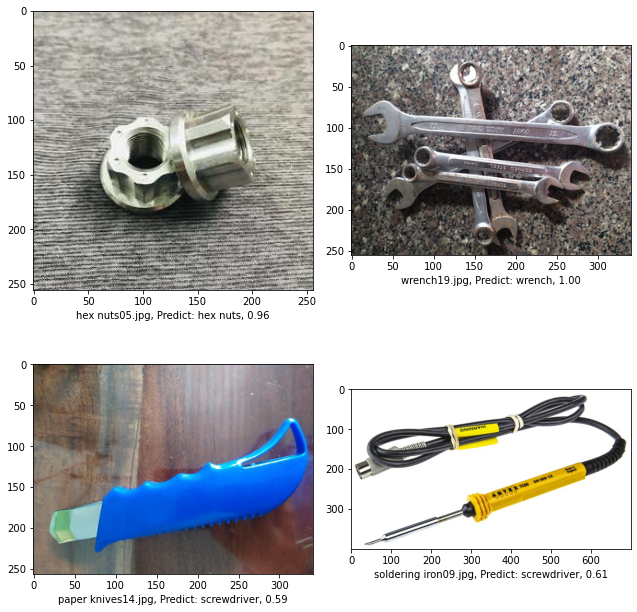

In [174]:
plt.figure(figsize=(9, 9))
value = [9, 17, 21, 39]
for i in value:
  name = file_name[i]
  img = Image.open(path +  file_name[i])
  plt.subplot(2, 2, value.index(i)+1)
  plt.imshow(img)
  plt.xlabel('%s, Predict: %s, %.2f' %(file_name[i], categories[top1_id[i]], top1_prob[i]))
plt.tight_layout()
plt.show()